Shape of training set: (251, 10)
Shape of test set: (124, 10)


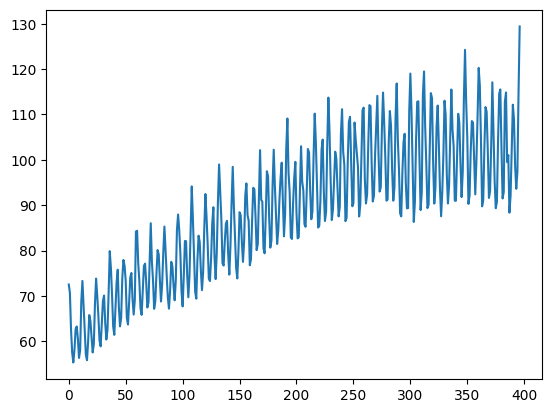

In [11]:
"""
Dataset from: https://www.kaggle.com/rakannimer/air-passengers
International Airline Passengers prediction problem.
This is a problem where, given a year and a month, the task is to predict 
the number of international airline passengers in units of 1,000. 
The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.
"""

import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

# load the dataset
dataframe = read_csv('Electric_Production.csv', usecols=[1])
plt.plot(dataframe)

#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32') #Convert values to float

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


# We cannot fit the model like we normally do for image processing where we have
#X and Y. We need to transform our data into something that looks like X and Y values.
# This way it can be trained on a sequence rather than indvidual datapoints. 
# Let us convert into n number of columns for X where we feed sequence of numbers
#then the final column as Y where we provide the next number in the sequence as output.
# So let us convert an array of values into a dataset matrix

#seq_size is the number of previous time steps to use as 
#input variables to predict the next time period.

#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

In [12]:
trainX[1]

array([0.20727438, 0.09630352, 0.02910393, 0.        , 0.03745866,
       0.09859806, 0.10707831, 0.07112324, 0.01350117, 0.03624523],
      dtype=float32)

In [ ]:
trainY

In [14]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [16]:
from keras.layers import LSTM, Flatten, RNN, GRU, SimpleRNNCell

In [18]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1],1))


In [19]:
trainX.shape

(251, 10, 1)

In [21]:
seq_size = 1

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

print('Single LSTM with hidden Dense...')
model = Sequential()

model.add(tf.keras.layers.SimpleRNN(512, input_shape=(None, seq_size)))
#kernel_regularizer=regularizers.l1(0.001),
#recurrent_regularizer=regularizers.l2(0.001),
#bias_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)
model.add(Dense(32,  activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
#                        verbose=1, mode='auto', restore_best_weights=True)
model.summary()
print('Train...')

Single LSTM with hidden Dense...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 512)               263168    
                                                                 
 dense_4 (Dense)             (None, 32)                16416     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 279617 (1.07 MB)
Trainable params: 279617 (1.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train...


In [26]:
weight = model.layers[0].get_weights()

In [27]:
for i in weight:
    print(i.shape)

(1, 512)
(512, 512)
(512,)


In [28]:
for i in model.layers[0].weights:
    print(i.shape)

(1, 512)
(512, 512)
(512,)


In [ ]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=0, epochs=250)

In [30]:
# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

4/4 [==============================] - 0s 3ms/step


In [31]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [39]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.90 RMSE
Test Score: 3.35 RMSE


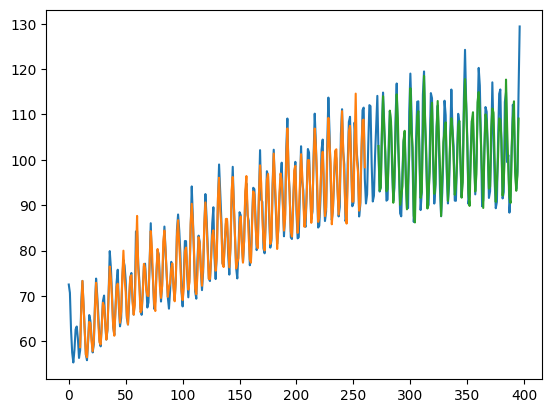

In [47]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[10:len(trainPredict)+10, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-len(testPredict)-1:-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

---

In [50]:
import pandas as pd
dataset = pd.read_csv('Electric_Production.csv', index_col=['DATE'], parse_dates=['DATE'])

In [63]:
data = pd.DataFrame(dataset.copy())
data.columns = ["y"]

#data.index = data.index.to_datetime()
data["year"] = data.index.year
data["weekday"] = data.index.weekday
data['month'] = data.index.month
data.head()

,y,year,weekday,month
DATE,,,,
1985-01-01,72.5052,1985,1,1
1985-02-01,70.6720,1985,4,2
1985-03-01,62.4502,1985,4,3
1985-04-01,57.4714,1985,0,4
1985-05-01,55.3151,1985,2,5


In [64]:
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
data = scaler.fit_transform(data)

In [65]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [158]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        
    #data.index = data.index.to_datetime()
    data["year"] = data.index.year
    data["weekday"] = data.index.weekday
    data['month'] = data.index.month
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
    data["year_average"] = list(map(code_mean(data[:test_index], 'year', "y").get, data.year))
    data["month_average"] = list(map(code_mean(data[:test_index], 'month', "y").get, data.month))

    # выкидываем закодированные средними признаки 
    data.drop(["year", "month", "weekday"], axis=1, inplace=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.iloc[:test_index]
    X_test = data.iloc[test_index:]

    X_train = X_train.dropna()
    X_train = X_train.reset_index(drop=True)
    y_train = X_train['y']
    X_train = X_train.drop(["y"], axis=1)

    X_test = X_test.dropna()
    X_test = X_test.reset_index(drop=True)
    y_test = X_test['y']
    X_test = X_test.drop(["y"], axis=1)

    return X_train, X_test, y_train, y_test

In [181]:
X_train, X_test, y_train, y_test = prepareData(dataset, 5, 15, 0.2)

In [182]:
X_train

,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,weekday_average,year_average,month_average
0,56.3154,60.5846,63.2485,62.6202,58.0904,55.3151,57.4714,62.4502,70.6720,72.5052,85.625427,62.709892,85.132915
1,58.0005,56.3154,60.5846,63.2485,62.6202,58.0904,55.3151,57.4714,62.4502,70.6720,86.147167,62.709892,76.857856
2,68.7145,58.0005,56.3154,60.5846,63.2485,62.6202,58.0904,55.3151,57.4714,62.4502,86.158341,62.709892,76.700222
3,73.3057,68.7145,58.0005,56.3154,60.5846,63.2485,62.6202,58.0904,55.3151,57.4714,84.210727,62.709892,83.436562
4,67.9869,73.3057,68.7145,58.0005,56.3154,60.5846,63.2485,62.6202,58.0904,55.3151,86.147167,62.709892,90.323581
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,112.9014,112.8066,104.3538,90.8364,86.3000,98.2672,110.5330,119.0166,110.6844,89.3585,85.625427,101.078840,97.706633
299,100.1209,112.9014,112.8066,104.3538,90.8364,86.3000,98.2672,110.5330,119.0166,110.6844,86.147167,101.078840,91.097463
300,88.9251,100.1209,112.9014,112.8066,104.3538,90.8364,86.3000,98.2672,110.5330,119.0166,86.147167,101.078840,85.132915
301,92.7750,88.9251,100.1209,112.9014,112.8066,104.3538,90.8364,86.3000,98.2672,110.5330,84.609165,101.078840,76.857856


In [183]:
y_train

0       62.2221
1       57.0329
2       55.8137
3       59.9005
4       65.7655
         ...   
298    119.4880
299    107.3753
300     99.1028
301     89.3583
302     90.0698
Name: y, Length: 303, dtype: float64

In [184]:
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset_train = scaler.fit_transform(X_train)
dataset_test = scaler.transform(X_test)

In [185]:
dataset_test.shape

(7, 13)

In [186]:
window_size = 5
windowed_train = np.lib.stride_tricks.sliding_window_view(dataset_train, (window_size, dataset_train.shape[1]))
windowed_test = np.lib.stride_tricks.sliding_window_view(dataset_test, (window_size, dataset_test.shape[1]))

In [187]:
windowed_test.shape

(3, 1, 5, 13)

In [188]:
windowed_train = np.squeeze(windowed_train, axis=1)
windowed_test = np.squeeze(windowed_test, axis=1)

In [189]:
windowed_train.shape

(299, 5, 13)

In [190]:
y_train=y_train[window_size - 1:]

In [191]:
y_train.shape

(299,)

In [149]:
windowed_test.shape

(3, 5, 13)

In [192]:
y_test=y_test[window_size - 1:]

In [193]:
y_test.shape

(3,)

In [194]:
y_train.mean()

86.73114481605352

In [195]:
y_test = y_test/y_train.mean()

In [196]:
y_train = y_train/y_train.mean()

In [199]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
print('Single LSTM with hidden Dense...')
model = Sequential()
seq_size = len(X_train.columns)
model.add(tf.keras.layers.LSTM(512, input_shape=(None, seq_size)))
model.add(Dense(32,  activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_absolute_error', optimizer='adam')
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
#                        verbose=1, mode='auto', restore_best_weights=True)
model.summary()
print('Train...')

Single LSTM with hidden Dense...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 512)               1077248   
                                                                 
 dense_10 (Dense)            (None, 32)                16416     
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1093697 (4.17 MB)
Trainable params: 1093697 (4.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train...


In [201]:
model.fit(windowed_train, y_train, validation_data=(windowed_test, y_test),
          verbose=1, epochs=10)

Epoch 1/10
10/10 [==============================] - 0s 22ms/step - loss: 0.2194 - val_loss: 0.6274
Epoch 2/10
10/10 [==============================] - 0s 17ms/step - loss: 0.2374 - val_loss: 0.5922
Epoch 3/10
10/10 [==============================] - 0s 17ms/step - loss: 0.1428 - val_loss: 0.5691
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 0.1051 - val_loss: 0.5310
Epoch 5/10
10/10 [==============================] - 0s 16ms/step - loss: 0.1281 - val_loss: 0.5147
Epoch 6/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0753 - val_loss: 0.5348
Epoch 7/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0685 - val_loss: 0.5244
Epoch 8/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0788 - val_loss: 0.4410
Epoch 9/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0942 - val_loss: 0.5317
Epoch 10/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0754 - val_loss: 0.5377


In [202]:
# make predictions

trainPredict = model.predict(windowed_train)
testPredict = model.predict(windowed_test)

1/1 [==============================] - 0s 18ms/step


In [203]:
trainPredict.shape

(299, 1)

---

In [208]:
#32000 -  размерность словаря. 
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(1000, 64, input_length=10))
input_array = np.random.randint(1000, size=(32, 10))
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array.shape)

1/1 [==============================] - 0s 35ms/step
(32, 10, 64)


In [209]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 64)            64000     
                                                                 
Total params: 64000 (250.00 KB)
Trainable params: 64000 (250.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [210]:
for i in model.layers[0].weights:
    print(i.shape)

(1000, 64)
